## Some imports

In [22]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

## Data preprocessing
Dataset contains drug-like compounds which are potential inhibitors of GP120 - CD4 interaction. Compounds are stored in SMILES format. Also data contains binding energy for molecules.

In [23]:
smifile = 'gp120_cleaned.csv'
data = pd.read_csv(smifile, header=0)
del data['babel_smiles'], data['filepath_smi']
data.head()

,energy,smiles
0,-8.1,Cc1ccc(C(=O)CN2NN=C(C3CC3)[C@@H]2c2ccccc2F)cc1
1,-8.0,CCOC1=CC(=O)[C@@H](CC2=NNN(CC(=O)c3ccc(C)cc3)[...
2,-7.7,Cc1ccc(C(=O)CN2NN=C(CNC(C)(C)CO)[C@H]2C(C)(C)C...
3,-7.1,Cc1ccc(OC[C@H]2C(CN3CCOCC3)=NNN2CC(=O)c2ccc(C)...
4,-6.8,Cc1ccc(C(=O)CN2NN=C(CCO)[C@@H]2C2(O)CC2)cc1


### Train and test sets creation

In [24]:
full_train = data.sample(frac=0.8, random_state=42) 
full_test = data.drop(full_train.index)

smiles_train, energy_train = full_train.smiles, full_train.energy
smiles_test, energy_test = full_test.smiles, full_test.energy


print(smiles_train.shape)
print(smiles_test.shape)

(57130,)
(14283,)


### SMILES alphabet

In [25]:
charset = set("".join(list(data.smiles)) + "!E")
char_to_int = dict((c, i) for i, c in enumerate(charset))
int_to_char = dict((i, c) for i, c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5

print(f'alphabet size: {len(charset)}')
print(f'max smiles len: {embed}')

alphabet size: 32
max smiles len: 95


### SMILES length distribution

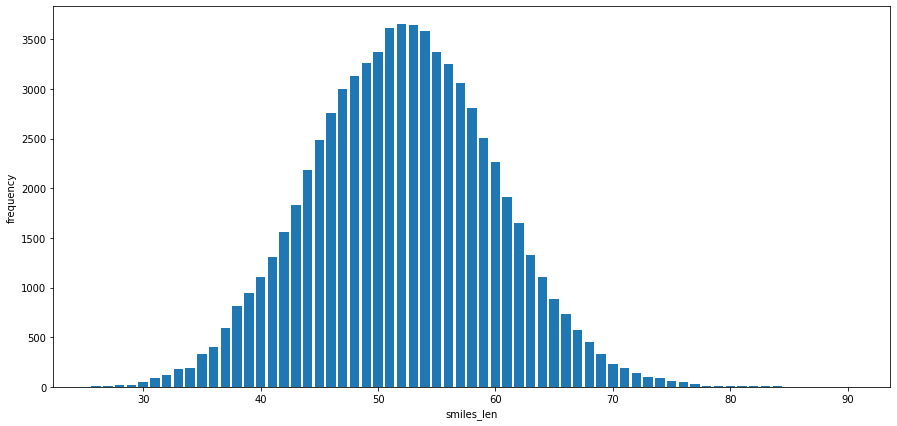

In [26]:
data['smiles_len'] = np.array([len(smiles) for smiles in data.smiles])
frequencies = data.smiles_len.value_counts()

plt.rcParams["figure.figsize"] = (15, 7)
plt.bar(frequencies.index, frequencies)
plt.xlabel('smiles_len')
plt.ylabel('frequency')
plt.show()

### Distribution of chars frequencies

In [27]:
from copy import deepcopy

def count_char_freq(char):
    return sum([smile.count(char) for smile in data.smiles])

tmp_char_set = deepcopy(charset)
tmp_char_set.remove('!')
tmp_char_set.remove('E')
tmp_char_set = list(tmp_char_set)


char_freqs = np.array([count_char_freq(char) for char in tmp_char_set])
freqs_df = pd.DataFrame(char_freqs, index=tmp_char_set, columns=['frequency'])
freqs_df = freqs_df.sort_values('frequency')
freqs_df[:10]

,frequency
6,2
.,25
P,27
I,30
5,94
\,1198
o,1795
s,2097
/,5044
+,5671


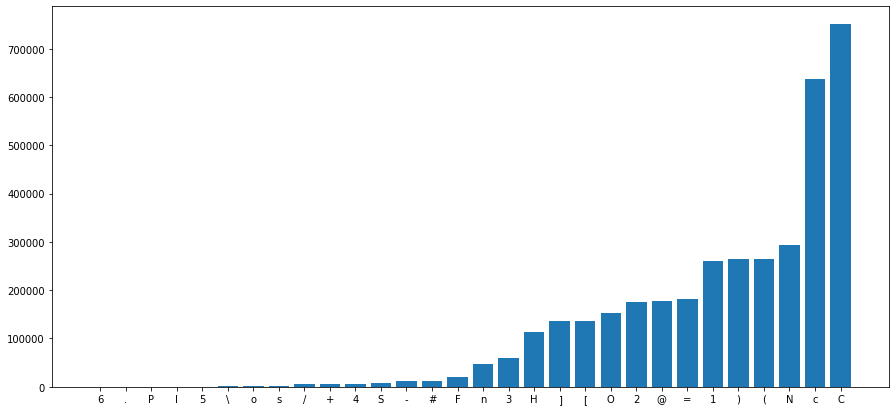

In [28]:
plt.rcParams["figure.figsize"] = (15, 7)
plt.bar(freqs_df.index, freqs_df.frequency)
plt.show()

### SMILES vectorization

In [29]:
def vectorize(smiles):
    one_hot = np.zeros((smiles.shape[0], embed, len(charset)), dtype=np.int8)
    for i, smile in enumerate(smiles):
        one_hot[i, 0, char_to_int["!"]] = 1
        for j, c in enumerate(smile):
            one_hot[i, j + 1, char_to_int[c]] = 1
        one_hot[i, len(smile) + 1:, char_to_int["E"]] = 1
    return one_hot[:, 0:-1, :], one_hot[:, 1:, :]

CC[C@@](C)(OC(C)=O)[C@H]1C(CN2CCOCC2)=NNN1CCc1ccc(-c2ncc[nH]2)cc1


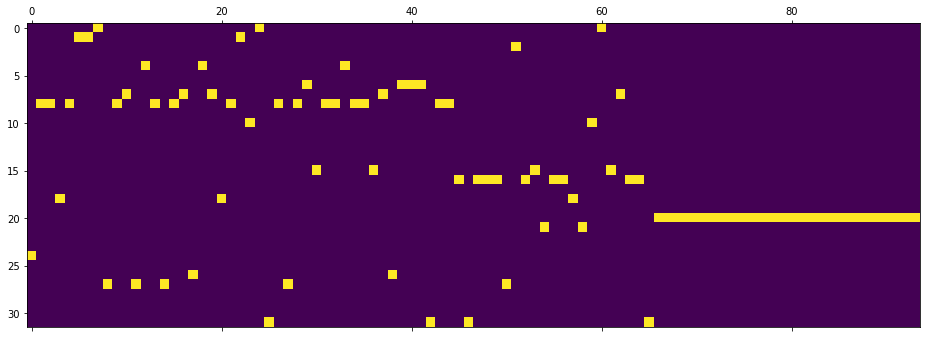

In [30]:
X_train, Y_train = vectorize(smiles_train.values)
X_test, Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[0])
plt.matshow(X_train[0].T)
plt.show()

### Binding energy scaling
Actually, I don't know if scaling of energy is a good idea, but without scaling model generates only invalid SMILES. After energy scaling generated compounds are valid, but I suppose that model can just treat this feature as useless and new compounds don't have expected binding energy. Maybe adding `BatchNormalization` layers to decoder will be useful.

In [31]:
from sklearn.preprocessing import MinMaxScaler

energy_train = energy_train.to_frame()
energy_test = energy_test.to_frame()

sc = MinMaxScaler().fit(energy_train)
energy_train = sc.transform(energy_train)
energy_test = sc.transform(energy_test)

## Model definition and training

In [64]:
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 128

unroll = False
encoder_inputs = Input(shape=input_shape, name='Smiles_input_1')

encoder_lstm = LSTM(lstm_dim, return_state=True,
                    unroll=unroll, name='Encoder_lstm')

encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

states = Concatenate(axis=-1, name='States_concat')([state_h, state_c])
neck = Dense(latent_dim, activation="relu", name='Encoder_neck')
neck_outputs = neck(states)

free_energy_inputs = Input(shape=(1,), name='Energy_input')
concatenate = Concatenate(axis=-1, name='Energy_concat')
energy_concat = concatenate([neck_outputs, free_energy_inputs])

decode_h = Dense(lstm_dim, name='State_h_decoder', activation="relu")
decode_c = Dense(lstm_dim, name='State_c_decoder', activation="relu")
state_h_decoded = decode_h(energy_concat)
state_c_decoded = decode_c(energy_concat)

encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape, name='Smiles_input_2')


decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    name='Decoder_lstm'
                    )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax', name='Decoder_output')
decoder_outputs = decoder_dense(decoder_outputs)

In [65]:
model = Model([encoder_inputs, decoder_inputs, free_energy_inputs], decoder_outputs, name='Lstm_autoencoder')
plot_model(model, to_file='model.png', show_layer_activations=True)
print(model.summary())

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "Lstm_autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Smiles_input_1 (InputLayer)    [(None, 94, 32)]     0           []                               
                                                                                                  
 Encoder_lstm (LSTM)            [(None, 128),        82432       ['Smiles_input_1[0][0]']         
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 States_concat (Conc

In [66]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001, verbose=1, min_delta=1e-5)

opt = Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [67]:
import pickle

def save_history():
    with open("Blog_history.pickle", "wb") as f:
        pickle.dump(h.history, f)

def load_history():
    with open("Blog_history.pickle", "rb") as f:
        return pickle.load(f)

In [68]:
model.fit([X_train, X_train, energy_train], Y_train,
                    epochs=75,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=([X_test, X_test, energy_test], Y_test))

Epoch 1/75
224/224 [==============================] - 12s 42ms/step - loss: 0.8683 - val_loss: 0.4370 - lr: 0.0050
Epoch 2/75
224/224 [==============================] - 8s 37ms/step - loss: 0.3383 - val_loss: 0.2824 - lr: 0.0050
Epoch 3/75
224/224 [==============================] - 8s 37ms/step - loss: 0.2581 - val_loss: 0.2449 - lr: 0.0050
Epoch 4/75
224/224 [==============================] - 8s 37ms/step - loss: 0.2282 - val_loss: 0.2188 - lr: 0.0050
Epoch 5/75
224/224 [==============================] - 8s 37ms/step - loss: 0.2073 - val_loss: 0.2013 - lr: 0.0050
Epoch 6/75
224/224 [==============================] - 8s 38ms/step - loss: 0.1944 - val_loss: 0.1891 - lr: 0.0050
Epoch 7/75
224/224 [==============================] - 10s 44ms/step - loss: 0.1805 - val_loss: 0.1775 - lr: 0.0050
Epoch 8/75
224/224 [==============================] - 9s 40ms/step - loss: 0.1707 - val_loss: 0.1692 - lr: 0.0050
Epoch 9/75
224/224 [==============================] - 9s 39ms/step - loss: 0.1627 - va

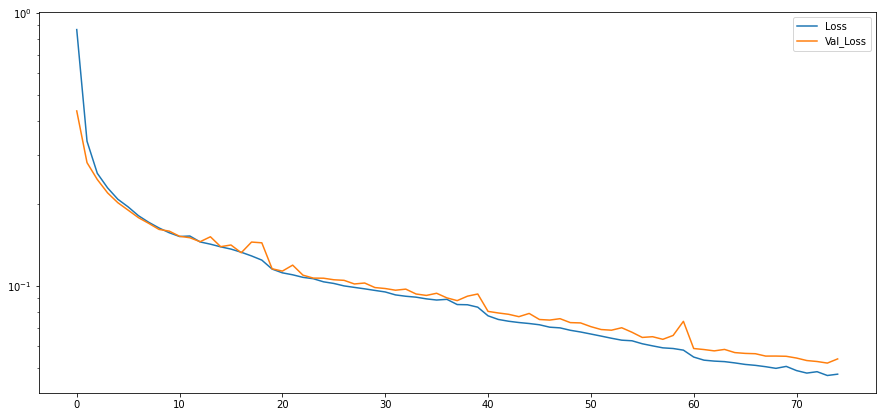

In [71]:
save_history()

plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")

plt.yscale("log")
plt.legend()
plt.show()

## Model splitting into encoder and decoder

In [72]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)

In [73]:
latent_input = Input(shape=(latent_dim,))
energy_input = Input(shape=(1,))

energy_concat_2 = concatenate([latent_input, energy_input])

state_h_decoded_2 = decode_h(energy_concat_2)
state_c_decoded_2 = decode_c(energy_concat_2)

latent_to_states_model = Model([latent_input, energy_input], 
                               [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 Energy_concat (Concatenate)    (None, 65)           0           ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 State_h_decoder (Dense)        (None, 128)          8448        ['Energy_concat[1][0]']    

In [74]:
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))

inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

In [75]:
sample_model.layers[1].set_weights(model.layers[-2].get_weights())
sample_model.layers[2].set_weights(model.layers[-1].get_weights())

sample_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(1, 1, 32)]              0         
                                                                 
 lstm_1 (LSTM)               (1, 1, 128)               82432     
                                                                 
 dense_1 (Dense)             (1, 1, 32)                4128      
                                                                 
Total params: 86,560
Trainable params: 86,560
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.save('autoencoder_model')
smiles_to_latent_model.save('autoencoder_smiles_to_latent_model')
latent_to_states_model.save('autoencoder_latent_to_states_model')
sample_model.save('autoencoder_sample_model')

## New compounds generation

In [ ]:
model = keras.models.load_model('autoencoder_model')
smiles_to_latent_model = keras.models.load_model('autoencoder_smiles_to_latent_model')
latent_to_states_model = keras.models.load_model('autoencoder_latent_to_states_model')
sample_model = keras.models.load_model('autoencoder_sample_model')

### Latent space creation

In [76]:
x_latent = smiles_to_latent_model.predict(X_test)

### Converting from latent space to SMILES

In [77]:
def latent_to_smiles(latent, free_energy):
    states = latent_to_states_model.predict([latent, free_energy])
    sample_model.layers[1].reset_states(states=[states[0], states[1]])
    # adding start char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1, 1, len(charset)))
    samplevec[0,0,startidx] = 1
    smiles = ""
    # predict next symbol
    for i in range(embed):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1, 1, len(charset)))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [78]:
# comparing original molecule with reconstructed via autoencoder

compound_index = 20

free_energy = energy_test[compound_index]

smiles = latent_to_smiles(x_latent[compound_index:compound_index + 1], free_energy)
print(smiles)
print(smiles_test.iloc[compound_index])

CCCCC1=NNN(CC(=O)c2ccc(C)cc2)[C@H]1c1cncc(C(=O)O)c1
CCCNCC1=NNN(CC(=O)c2ccc(C)cc2)[C@@H]1c1ccccc1


### Testing validity of generated SMILES
To test if SMILES are reconstructed correctly, 500 compounds from test set were passed through autoencoder, and then some checks were performed.

In [ ]:
from tqdm import tqdm


equal_smiles = 0
valid_smiles = 0

my_range = range(500)

with tqdm(my_range, 
          bar_format="{bar} : {percentage:.2f}% | "
                     "valid: {postfix[0]:.2f}% | "
                     "equal: {postfix[1]:.2f}% | "
                     "elapsed: {elapsed} | "
                     "remaining: {remaining}", 
          postfix=[0, 0]) as t:
    for i in my_range:
        smiles = latent_to_smiles(x_latent[i:i + 1], energy_test[i])
        if smiles == smiles_test.iloc[i]:
            equal_smiles += 1
            valid_smiles += 1  
        elif Chem.MolFromSmiles(smiles):
            valid_smiles += 1
        t.postfix[0] = valid_smiles / (i + 1) * 100
        t.postfix[1] = equal_smiles / (i + 1) * 100
        t.update()


██████████ : 100.00% | valid: 98.20% | equal: 1.20% | elapsed: 24:20 | remaining: 00:00


### Calculating binding energy
We will use average energy of inhibitors from dataset, which is $\approx -6.9$

In [ ]:
free_energy = np.mean(data.energy)
free_energy = sc.transform(pd.DataFrame([free_energy]))

### Generation from latent space with noise adding
To generate new compounds, we can add random noise vector to `x_latent` and get molecules with similar properties. Also we can set the binding energy we want to achieve.

In [99]:
def update_progress_bar(t, i, base_mols, unique_mols_per_it, same_mols, invalid_mols, scale, unique_mols_total):
    t.postfix[0] = (i + 1) * 100 / base_mols
    t.postfix[1] = unique_mols_per_it
    t.postfix[2] = same_mols
    t.postfix[3] = invalid_mols
    t.postfix[4] = scale
    t.postfix[5] = unique_mols_total
    t.update()

In [101]:
from tqdm import tqdm
from rdkit import RDLogger


RDLogger.DisableLog('rdApp.*')

base_mols = 200
unique_mols_total = 0

smiles_dict = {smiles_test.iloc[i]: [] for i in range(base_mols)}
smiles_enumerate = enumerate(smiles_dict)


with tqdm(smiles_enumerate, 
          bar_format="{postfix[0]:.1f}% | "
                     "unique/it: {postfix[1]} | "
                     "same: {postfix[2]} | "
                     "invalid: {postfix[3]} | "
                     "scale: {postfix[4]:.1f} | "
                     "unique total: {postfix[5]} | "
                     "elapsed: {elapsed} | ", postfix = [0] * 6) as t:

    for i, smiles in smiles_enumerate:
        scale = 0.1
        same_mols = invalid_mols = unique_mols_per_it = 0
        unique_mols = set()
        latent = x_latent[i:i + 1]

        update_progress_bar(t, i, base_mols, unique_mols_per_it, same_mols, invalid_mols, scale, unique_mols_total)

        while unique_mols_per_it < 5:
            latent_r = latent + scale * (np.random.randn(latent.shape[1]))
            new_smiles = latent_to_smiles(latent_r, free_energy)
            mol = Chem.MolFromSmiles(new_smiles)
            if mol:
                if new_smiles not in unique_mols and new_smiles != smiles:
                    unique_mols.add(new_smiles)
                    unique_mols_per_it += 1
                    unique_mols_total += 1
                else:
                    same_mols += 1
            else:
                invalid_mols += 1

            if same_mols > 5:
                scale += 0.1

            if invalid_mols > 5 or scale > 1.5:
                break

            update_progress_bar(t, i, base_mols, unique_mols_per_it, same_mols, invalid_mols, scale, unique_mols_total)

        smiles_dict[smiles] = list(unique_mols)

100.0% | unique/it: 5 | same: 8 | invalid: 1 | scale: 1.0 | unique total: 836 | elapsed: 2:27:03 | 


In [103]:
import json


with open('new_compounds.json', 'w') as f:
    json.dump(smiles_dict, f, indent=4)

## Generated molecules visualization
There are 2D and 3D structures of molecules generated based on first compound from test set.

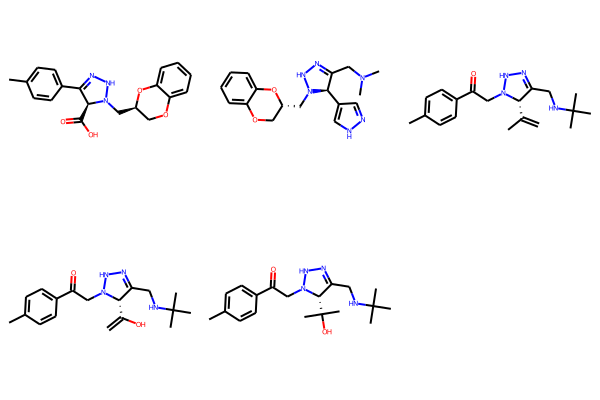

In [107]:
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_dict[smiles_test.iloc[0]]]
Draw.MolsToGridImage(mols, molsPerRow=3)

In [110]:
import py3Dmol

from rdkit import Chem
from rdkit.Chem import AllChem

def makeblock(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    mblock = Chem.MolToMolBlock(mol)
    return mblock

def render_mol(xyz):
    xyzview = py3Dmol.view()
    xyzview.addModel(xyz,'mol')
    xyzview.setStyle({'stick':{}})
    xyzview.setBackgroundColor('white')
    xyzview.zoomTo()
    xyzview.show()

formula = smiles_dict[smiles_test.iloc[0]][0]
    
blk = makeblock(formula)
print(formula)
render_mol(blk)

Cc1ccc(C2=NNN(C[C@@H]3COc4ccccc4O3)[C@H]2C(=O)O)cc1


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol